## Vertical Profile Tutorial
This is an educational toolkit to demonstrate how to plot the CESM1 data as a vertical profile.
Vertical profiles are a vertical trend chart that display a parameter measured at a specified depth, location, and time frame. In this notebook, we will be covering how to create vertical profiles plot for the historic, present day and future projected data.

### CESM1 Large Ensemble
This portion of the notebook will detail how to get access to the CESM1 large Ensemble dataset, which is hosted on Amazon Web Services. Since it is hosted on Amazon Web services, the users accessing this data will not have to create a separate account. Directions will be followed very similarly to a NCAR repository labeled CESM LENS on AWS.
This has been modified to also include functionality to load a zarr-format grid file containing the latitude and longitude information for CESM1, which for some reason are not included in the data files.
Things to note about the data we are accessing:
The notebook will be accessing the Ocean model for CESM1
Because of this the grid file used here is only for OCEAN variables; the atmosphere and land variables have different lat and lon information.
For most ocean variables, latitude and longitude are called "TLAT" and "TLONG".
This notebook will only be looking at a few variables as an example. If you are inclined to view other variables, a whole list can be found here
To first open connection to where the files are housed, we need to open the connection by using the intake function

### Data Access
This notebook uses information from a notebook from the NCAR organization that can be found [here](https://ncar.github.io/CESM-Tutorial/notebooks/diagnostics/clm_ctsm/basics_clm.html#first-calculate-the-land-weights)


Accessing the data for this notebook will be done by using Pangeo's software to promote open access and reproducibility within this notebook. To properly ensure you have the correct packages installed that the 'Pangeo Environment' uses, make sure to view the .README for this repository found [here](https://github.com/Channelislanders/toolkit)
Here we are:
Accessing the OCN model dataset with RCP 8.5 and 20C runs.
Explain what these are
Narrowing down the columns to specific variables we aim to access.

pH,
DO,
salinity,
nutrients,
Temperature

For example:
col_ocntemp = col.search(
    frequency=["monthly"],
    component="ocn",
    variable="TEMP",
    experiment=["20C", "RCP85"],  
)

Loading in lat/lon data separately which was not in CESM1 as of March 2024.
This section works similar to accessing other catalogs, we will be using Zarr. More information on the library below.
https://zarr.readthedocs.io/en/stable/


### Importing Packages
In order to access the data, we'll need to import all necessary packages to do so. Below are the packages I have installed to use throughout this notebook:

In [1]:
# Packages needed generally
import matplotlib.pyplot as plt
from cartopy import crs as ccrs, feature as cfeature
import xarray as xr
import pandas as pd
import numpy as np
from rasterio import mask

# Packages needed for CESM1 example
import pprint
import intake
import requests
import aiohttp
import s3fs

# Packages needed for CMIP6
import zarr
import gcsfs

In [2]:
# Open original collection description file: CESM1 LENS
cat_url = "https://ncar-cesm-lens.s3-us-west-2.amazonaws.com/catalogs/aws-cesm1-le.json"
col = intake.open_esm_datastore(cat_url)
col

# Location of file containing grid (lat/lon) information for CESM1 LENS
grid_url="s3://ncar-cesm-lens/ocn/static/grid.zarr"

In [11]:
# Search for the sea surface variable, display the first few entries in the resulting data frame
col.search(variable="TEMP").df

# the experiments and variables we want to work with at a monthly frequency
col.search(experiment = ["RCP85", "20C"], frequency = "monthly", variable = ["O2","SALT","TEMP","SST"]).df



,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,O2,dissolved oxygen,ocn,20C,monthly,60.0,global_ocean,mmol/m^3,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-O2....
1,SALT,salinity,ocn,20C,monthly,60.0,global_ocean,gram/kilogram,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-SAL...
2,SST,potential temperature,ocn,20C,monthly,1.0,global_ocean,degC,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-SST...
3,TEMP,potential temperature,ocn,20C,monthly,60.0,global_ocean,degC,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-TEM...
4,O2,dissolved oxygen,ocn,RCP85,monthly,60.0,global_ocean,mmol/m^3,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-O...
5,SALT,salinity,ocn,RCP85,monthly,60.0,global_ocean,gram/kilogram,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-S...
6,SST,potential temperature,ocn,RCP85,monthly,1.0,global_ocean,degC,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-S...
7,TEMP,potential temperature,ocn,RCP85,monthly,60.0,global_ocean,degC,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-T...


In [6]:
# Get more detailed: search for monthly output for the 20th century and RCP8.5 
# ("HIST" is the 1850-1919 period, which is only in the first ensemble member, and "20C" is 1920-2005 which is common across all the other members)
col_ocntemp = col.search(
    frequency=["monthly"],
    component="ocn",
    variable="TEMP",
    experiment=["20C", "RCP85"],  
)

col_ocntemp.df

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,TEMP,potential temperature,ocn,20C,monthly,60.0,global_ocean,degC,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-TEM...
1,TEMP,potential temperature,ocn,RCP85,monthly,60.0,global_ocean,degC,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-T...


In [16]:
# Load catalog entries for subset into a dictionary of xarray datasets
dsets_TEMP = col_ocntemp.to_dataset_dict(
    zarr_kwargs={"consolidated": True}, storage_options={"anon": True}
)
print(f"\nDataset dictionary keys:\n {dsets_TEMP.keys()}")


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'



Dataset dictionary keys:
 dict_keys(['ocn.20C.monthly', 'ocn.RCP85.monthly'])


In [17]:
# Define Xarray datasets corresponding to the three experiments
ds_20C_temp = dsets_TEMP["ocn.20C.monthly"]
ds_RCP85_temp = dsets_TEMP["ocn.RCP85.monthly"]


In [18]:
ds_20C = dsets["ocn.20C.monthly"]
ds_RCP85 = dsets["ocn.RCP85.monthly"]

#for 1920 to 2000
ds_20C_ch_mean=ds_20C_ch.mean(dim="member_id")
ds_20C_world = ds_20C.mean(dim = "member_id")

NameError: name 'ds_20C_ch' is not defined

In [19]:
# plot for temperature
#example code

#slice for particular timeframe
time_slice = ds_20C.sel(time=slice("1950", "2000"))

#select the TEMP column and set z_t, which is depth to 0 for sea surface temeperature
#test_2000_2 = test_2.TEMP.sel(z_t = 0, method = "nearest")

#select a member_id
time_mem = time_slice.sel(member_id = 1)

#select just one point on the graph (this point is closest to channel islands)
point_temp = time_mem.isel(nlat=(280), nlon=(240))

#plot out time series graph
point_temp.plot()

#add title to graph
plt.title("Temperature Vertical Profile")

ValueError: Dataset.plot cannot be called directly. Use an explicit plot method, e.g. ds.plot.scatter(...)

gca() is a function in Matplotlib that stands for "get current axis." It is used to retrieve the current Axes instance on the current figure. When you call plt.gca(), you are essentially getting a reference to the current Axes object where your plot is being drawn.

In the context of the provided code, plt.gca() is used to retrieve the current Axes object after calling temp_2000_03.plot(), and then invert_yaxis() is called on this Axes object to invert the y-axis of the plot.

In [ ]:
# Get more detailed: search for monthly output for the 20th century and RCP8.5 
# ("HIST" is the 1850-1919 period, which is only in the first ensemble member, and "20C" is 1920-2005 which is common across all the other members)
col_ocnDO = col.search(
    frequency=["monthly"],
    component="ocn",
    variable="O2",
    experiment=["20C", "RCP85"],  
)

col_ocnDO.df

# Load catalog entries for subset into a dictionary of xarray datasets
dsets_DO = col_ocnDO.to_dataset_dict(
    zarr_kwargs={"consolidated": True}, storage_options={"anon": True}
)
print(f"\nDataset dictionary keys:\n {dsets_DO.keys()}")

# Define Xarray datasets corresponding to the three experiments
ds_20C_DO = dsets_DO["ocn.20C.monthly"]
ds_RCP85_DO = dsets_DO["ocn.RCP85.monthly"]

#look at ds_20C dataset
ds_20C_DO

# plot for DO

slice_time_DO = ds_20C_DO.O2.mean(dim = ["member_id", "time"])

DO_2000 = slice_time_DO.isel(z_t = [1])

DO_2000_03 = DO_2000.isel(nlat = 280, nlon = 240)

DO_2000_03.plot()

# Plotting the dissolved oxygen with inverted y-axis
DO_2000_03.plot(y='z_t')
plt.gca().invert_yaxis()
plt.show()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'



Dataset dictionary keys:
 dict_keys(['ocn.RCP85.monthly', 'ocn.20C.monthly'])



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'



Dataset dictionary keys:
 dict_keys(['ocn.RCP85.monthly', 'ocn.20C.monthly'])


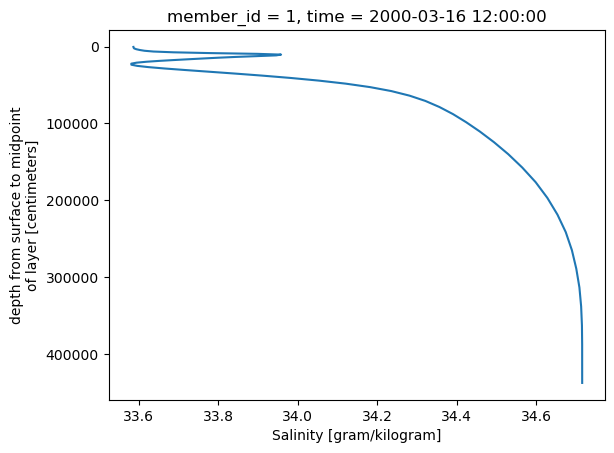

In [21]:
# Get more detailed: search for monthly output for the 20th century and RCP8.5 
# ("HIST" is the 1850-1919 period, which is only in the first ensemble member, and "20C" is 1920-2005 which is common across all the other members)
col_ocnSALT = col.search(
    frequency=["monthly"],
    component="ocn",
    variable="SALT",
    experiment=["20C", "RCP85"],  
)

col_ocnSALT.df

# Load catalog entries for subset into a dictionary of xarray datasets
dsets_SALT = col_ocnSALT.to_dataset_dict(
    zarr_kwargs={"consolidated": True}, storage_options={"anon": True}
)
print(f"\nDataset dictionary keys:\n {dsets_SALT.keys()}")

# Define Xarray datasets corresponding to the three experiments
ds_20C_SALT = dsets_SALT["ocn.20C.monthly"]
ds_RCP85_SALT = dsets_SALT["ocn.RCP85.monthly"]

# plot for DO

slice_time_SALT = ds_20C_SALT.sel(time = "2000-03")

SALT_2000 = slice_time_SALT.mean(dim = "member_id")

SALT_2000_03 = SALT_2000.isel(nlat = 280, nlon = 240)

# Select the variable you want to plot
SALT_2000_03_dataarray = SALT_2000_03['SALT']

# Plot the data
SALT_2000_03_dataarray.plot(y='z_t')

# Plotting the salinity with inverted y-axis
plt.gca().invert_yaxis()
plt.show()




--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'



Dataset dictionary keys:
 dict_keys(['ocn.RCP85.monthly', 'ocn.20C.monthly'])


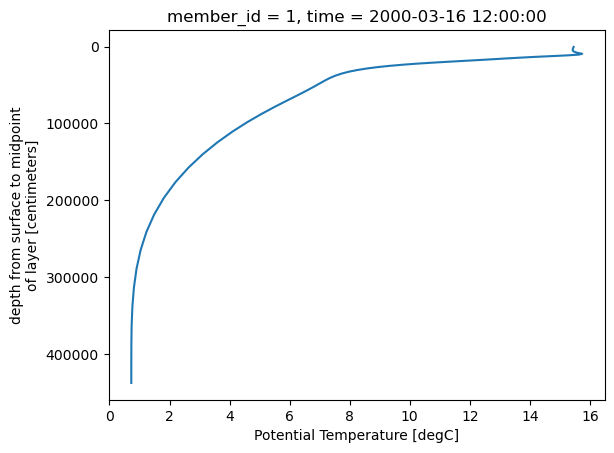

Text(0.5, 1.0, 'Sea Temperature Vertical Profile')

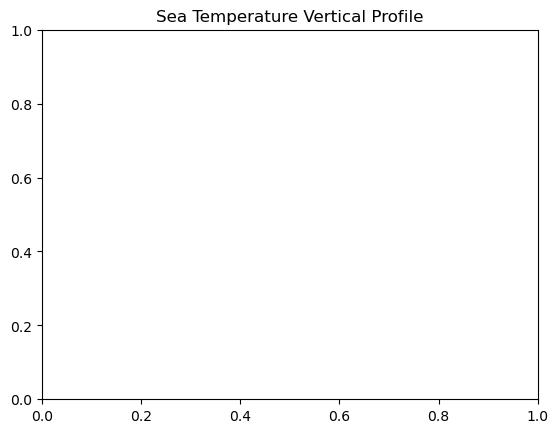

In [24]:
# Get more detailed: search for monthly output for the 20th century and RCP8.5 
col_ocnTEMP = col.search(
    frequency=["monthly"],
    component="ocn",
    variable="TEMP",
    experiment=["20C", "RCP85"],  
)

col_ocnTEMP.df

# Load catalog entries for subset into a dictionary of xarray datasets
dsets_TEMP = col_ocnTEMP.to_dataset_dict(
    zarr_kwargs={"consolidated": True}, storage_options={"anon": True}
)
print(f"\nDataset dictionary keys:\n {dsets_TEMP.keys()}")

# Define Xarray datasets corresponding to the three experiments
ds_20C_TEMP = dsets_TEMP["ocn.20C.monthly"]
ds_RCP85_TEMP = dsets_TEMP["ocn.RCP85.monthly"]

# plot for TEMP

slice_time_TEMP = ds_20C_TEMP.sel(time = "2000-03")

TEMP_2000 = slice_time_TEMP.sel(member_id = 1)

TEMP_2000_03 = TEMP_2000.isel(nlat = 280, nlon = 240)

# Select the variable you want to plot
TEMP_2000_03_dataarray = TEMP_2000_03['TEMP']

# Plot the data
TEMP_2000_03_dataarray.plot(y='z_t')

# Plotting the salinity with inverted y-axis
plt.gca().invert_yaxis()
plt.show()
